In [1]:
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf


In [2]:
df = pd.read_csv('datasets/star_classification.csv')

In [3]:
df.columns

Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

# Prepare the dataset

In [5]:
classes = df['class'].copy()

# For dealing with group in cross validation
# cam_col is selected for this case
group = df['cam_col'].copy()

# extract all of features that is the best for using
# drop all of _id type for this case 
features = df[['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'redshift',]].copy()

# Data visualization

### Visualize the density base on each classes of each column

In [6]:
import matplotlib.pyplot as plt

# seaborn theme
sns.set_palette(sns.color_palette("husl",6))

cls_label_arr = classes.unique()

def dense_plot(focus_col):
    for label in cls_label_arr:
        sns.kdeplot(data=df[classes == label][focus_col], label = label)
    sns.kdeplot(data=df[focus_col], label = focus_col)
    plt.legend()

def dense_plot_log(focus_col):
    for label in cls_label_arr:
        sns.kdeplot(data=np.log(df[classes == label][focus_col]), label = label)
    sns.kdeplot(data=np.log(df[focus_col]), label = focus_col)
    plt.legend()

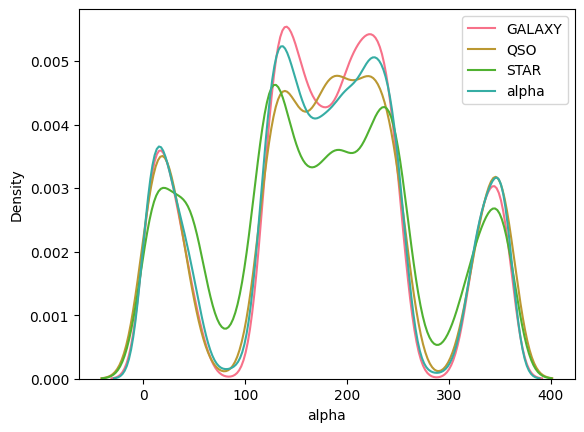

In [7]:
dense_plot('alpha')

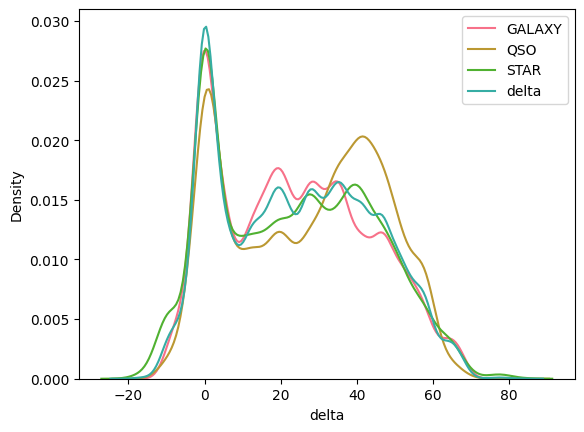

In [8]:
dense_plot('delta')

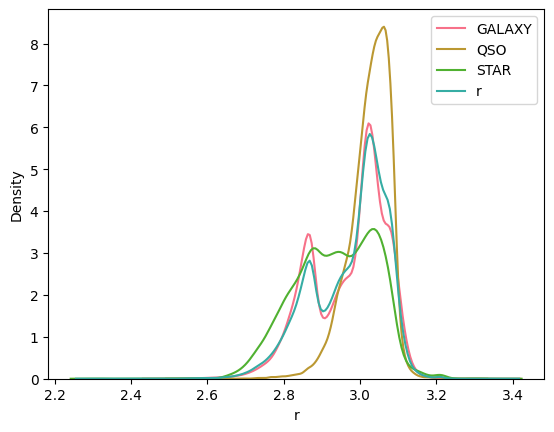

In [9]:
dense_plot_log('r')

## Visualize the density of each cam_col column

In [10]:
cam_cols_label_arr = df['cam_col'].unique()

def dense_plot_group(focus_col):
    for label in cam_cols_label_arr:
        sns.kdeplot(data=df[df['cam_col'] == label][focus_col], label = label)
    sns.kdeplot(data=df[focus_col], label = focus_col)
    plt.legend()

def dense_plot_log_group(focus_col):
    for label in cam_cols_label_arr:
        sns.kdeplot(data=np.log(df[df['cam_col'] == label][focus_col]), label = label)
    sns.kdeplot(data=np.log(df[focus_col]), label = focus_col)
    plt.legend()

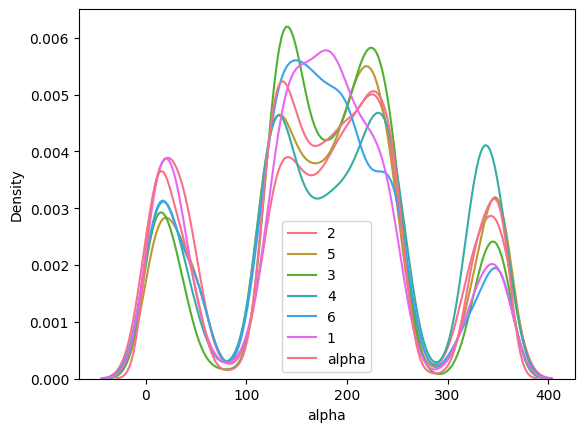

In [11]:
dense_plot_group('alpha')

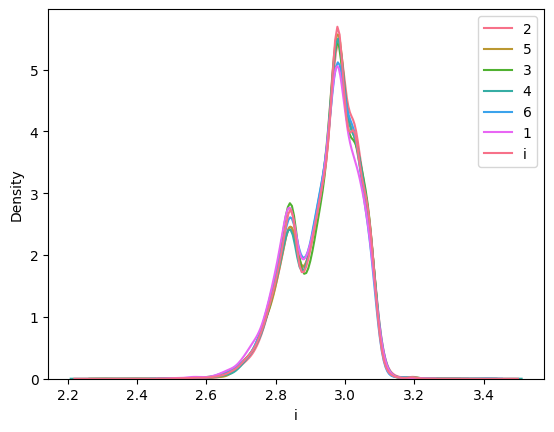

In [12]:
dense_plot_log_group('i')

## Cross Correlation visualization

<AxesSubplot: >

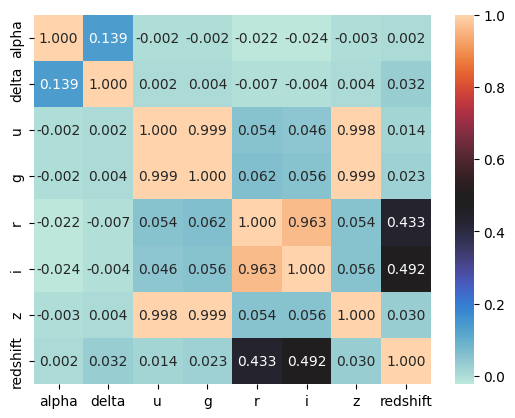

In [13]:
plt_corr = features.corr()
sns.heatmap(data=plt_corr, annot=True, fmt='.3f', cmap=sns.color_palette("icefire", as_cmap=True))

## Model build

In [14]:
def model_build( dense: list, activations: list, loss: object, optimizer:object, metrics:list,
                initializers: list = None, normalizer:object = None, activation_for_Ypred: object or str = None):          
    
    # Normalization check
    x_input = normalizer if normalizer else keras.layers.Flatten()
    
    # check if number of class is applied to dense list
    if dense[-1] != classes.nunique():
        dense.append(classes.nunique())
    
    # check if activation function for Ypred is applied
    if len(dense) != len(activations):
        if activation_for_Ypred is not None:
            activations.append(activation_for_Ypred)
        else:
            activations.append(None)
    
    # check if activation list is the same of dense list
    if len(dense) != len(activations):
        raise IndexError('Activations should be the same lenght of Dense')
    
    # Do they have inializers?
    if not initializers:
        initializers = [None for _ in range(len(dense))]
    elif len(initializers) != len(dense):
        raise IndexError('Initializer should be the same lenght of dense')
    
    model = keras.models.Sequential()
    model.add(x_input)
    
    _ = [
        model.add(keras.layers.Dense(d, a, kernel_initializer = i)) for d,a,i in zip(dense,activations,initializers)
    ]
    
    model.compile( loss=loss, optimizer=optimizer, metrics=metrics )
    
    return model
    

## Model configuration

In [15]:
# In this case of dense the number of class will be apply automatically
dense = [32,64,128]

# In this case the activation for Ypred layer will be take it from Ypred_activateFX
Ypred_activateFX = keras.activations.sigmoid #ypred
activations = ['sigmoid','relu','relu'] # List of activation function

nomalizer = keras.layers.Normalization().adapt(features)

loss = keras.losses.CategoricalCrossentropy()
optimizer = keras.optimizers.Adam(learning_rate=0.001)
metrics = ['accuracy',keras.metrics.CategoricalAccuracy()]

# Pass it trough the function Bamm!!
model = model_build(dense = dense, activations = activations,
                    loss = loss, activation_for_Ypred = Ypred_activateFX,
                   optimizer=optimizer,metrics=metrics, normalizer=nomalizer)

In [16]:
model.build( input_shape=(None, len(features.columns)) )
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 32)                288       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,107
Trainable params: 11,107
Non-trainable params: 0
_________________________________________________________________


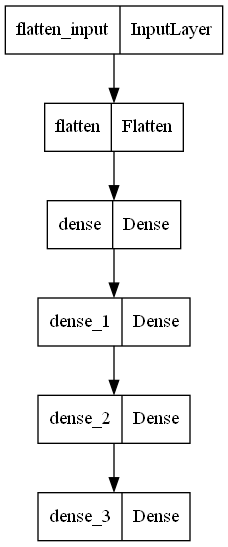

In [17]:
keras.utils.plot_model(model)

## One hot and convert to tensor

In [18]:
features_tensor = tf.convert_to_tensor(features)
one_h_class = keras.layers.CategoryEncoding(num_tokens = classes.nunique(),output_mode = 'one_hot')
one_h_class = one_h_class(pd.factorize(classes,sort=True)[0])
one_h_class = tf.convert_to_tensor(one_h_class)
one_h_class,features_tensor

(<tf.Tensor: shape=(100000, 3), dtype=float32, numpy=
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32)>,
 <tf.Tensor: shape=(100000, 8), dtype=float64, numpy=
 array([[1.35689107e+02, 3.24946318e+01, 2.38788200e+01, ...,
         1.91657300e+01, 1.87937100e+01, 6.34793600e-01],
        [1.44826101e+02, 3.12741849e+01, 2.47775900e+01, ...,
         2.11681200e+01, 2.16142700e+01, 7.79136000e-01],
        [1.42188790e+02, 3.55824442e+01, 2.52630700e+01, ...,
         1.93485700e+01, 1.89482700e+01, 6.44194500e-01],
        ...,
        [2.24587407e+02, 1.57007074e+01, 2.11691600e+01, ...,
         1.76903400e+01, 1.73522100e+01, 1.43365600e-01],
        [2.12268621e+02, 4.66603653e+01, 2.53503900e+01, ...,
         1.90725400e+01, 1.86248200e+01, 4.55039600e-01],
        [1.96896053e+02, 4.94646428e+01, 2.26217100e+01, ...,
         2.00095900e+01, 1.92807500e+01, 5.42944200e-0

## Utility

In [19]:
class CustomCallback(keras.callbacks.Callback):
    
    def __init__(self):
        self.custom_val = 0
    
    def on_epoch_begin(self, epoch, logs):
        pass
    
    def on_epoch_end(self, epoch, logs):
        pass
    
    def on_batch_end(self,batch,logs):
        pass
    
    def on_train_end(self, logs=None):
        pass

In [20]:
from dataclasses import dataclass,field

@dataclass
class FoldData:
    train_x: tf.Tensor = field()
    test_x: tf.Tensor = field()
    train_y: tf.Tensor = field()
    test_y: tf.Tensor = field()

class FoldManage:
    
    def extract_fold(self, fold_index:list , X, Y ):
        for train, test in fold_index:
            yield FoldData(
                train_x = tf.gather( X, train ),
                test_x = tf.gather( X, test ),
                train_y = tf.gather( Y, train ),
                test_y = tf.gather( Y, test ) 
            )
    
    # V V V
    
    def train_fold( self, batch_of_folds, ep, batch_size ):
        tf.keras.backend.clear_session()
        md_history = []
        for i,fold in enumerate(batch_of_folds):
            print(f'Fold: {i+1}')
            model.fit(
                fold.train_x,
                fold.train_y,
                epochs = ep,
                batch_size = batch_size,
            )
            
            print('Evaluating....')
            
            model.evaluate(
                fold.test_x,
                fold.test_y,
                batch_size = int(tf.size(fold.test_x))
            )
            
            

# CROSS VALIDATION !!
## KFold

In [21]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=50)
kf = kf.split(features_tensor,one_h_class,group)
tt = FoldManage()
a = tt.extract_fold( kf, features_tensor, one_h_class )
tt.train_fold(a,1,5000)

Fold: 1
20/20 [==============================] - 1s 4ms/step - loss: 0.9729 - accuracy: 0.5902 - categorical_accuracy: 0.5902
Evaluating....
1/1 [==============================] - 0s 143ms/step - loss: 0.8778 - accuracy: 0.6675 - categorical_accuracy: 0.6675
Fold: 2
20/20 [==============================] - 0s 4ms/step - loss: 0.9392 - accuracy: 0.5956 - categorical_accuracy: 0.5956
Evaluating....
1/1 [==============================] - 0s 20ms/step - loss: 0.9774 - accuracy: 0.5605 - categorical_accuracy: 0.5605
Fold: 3
20/20 [==============================] - 0s 4ms/step - loss: 0.9149 - accuracy: 0.6024 - categorical_accuracy: 0.6024
Evaluating....
1/1 [==============================] - 0s 20ms/step - loss: 0.9771 - accuracy: 0.5305 - categorical_accuracy: 0.5305
Fold: 4
20/20 [==============================] - 0s 4ms/step - loss: 0.8771 - accuracy: 0.6085 - categorical_accuracy: 0.6085
Evaluating....
1/1 [==============================] - 0s 21ms/step - loss: 0.7853 - accuracy: 0.664

1/1 [==============================] - 0s 22ms/step - loss: 0.2155 - accuracy: 0.9330 - categorical_accuracy: 0.9330
Fold: 33
20/20 [==============================] - 0s 7ms/step - loss: 0.2357 - accuracy: 0.9234 - categorical_accuracy: 0.9234
Evaluating....
1/1 [==============================] - 0s 22ms/step - loss: 0.2377 - accuracy: 0.9305 - categorical_accuracy: 0.9305
Fold: 34
20/20 [==============================] - 0s 7ms/step - loss: 0.2373 - accuracy: 0.9192 - categorical_accuracy: 0.9192
Evaluating....
1/1 [==============================] - 0s 23ms/step - loss: 0.2409 - accuracy: 0.9175 - categorical_accuracy: 0.9175
Fold: 35
20/20 [==============================] - 0s 7ms/step - loss: 0.2402 - accuracy: 0.9165 - categorical_accuracy: 0.9165
Evaluating....
1/1 [==============================] - 0s 22ms/step - loss: 0.2221 - accuracy: 0.9195 - categorical_accuracy: 0.9195
Fold: 36
20/20 [==============================] - 0s 7ms/step - loss: 0.2282 - accuracy: 0.9261 - categori

## Group KFold

In [22]:
from sklearn.model_selection import GroupKFold

kf = GroupKFold(n_splits=group.nunique())
kf = kf.split(features_tensor,one_h_class,group)
tt = FoldManage()
a = tt.extract_fold( kf, features_tensor, one_h_class )
tt.train_fold(a,1,None)

Fold: 1
2514/2514 [==============================] - 8s 3ms/step - loss: 0.2698 - accuracy: 0.8999 - categorical_accuracy: 0.8999
Evaluating....
1/1 [==============================] - 0s 63ms/step - loss: 0.2773 - accuracy: 0.8756 - categorical_accuracy: 0.8756
Fold: 2
2536/2536 [==============================] - 7s 3ms/step - loss: 0.2162 - accuracy: 0.9233 - categorical_accuracy: 0.9233
Evaluating....
1/1 [==============================] - 0s 31ms/step - loss: 0.2511 - accuracy: 0.9023 - categorical_accuracy: 0.9023
Fold: 3
2546/2546 [==============================] - 8s 3ms/step - loss: 0.1921 - accuracy: 0.9337 - categorical_accuracy: 0.9337
Evaluating....
1/1 [==============================] - 0s 27ms/step - loss: 0.2205 - accuracy: 0.9268 - categorical_accuracy: 0.9268
Fold: 4
2591/2591 [==============================] - 8s 3ms/step - loss: 0.1727 - accuracy: 0.9426 - categorical_accuracy: 0.9426
Evaluating....
1/1 [==============================] - 0s 28ms/step - loss: 0.8867 - 

# ShuffleSplit

In [23]:
from sklearn.model_selection import ShuffleSplit

kf = ShuffleSplit(n_splits=group.nunique())
kf = kf.split(features_tensor,one_h_class,group)
tt = FoldManage()
a = tt.extract_fold( kf, features_tensor, one_h_class )
tt.train_fold(a,1,None)

Fold: 1
2813/2813 [==============================] - 9s 3ms/step - loss: 0.1517 - accuracy: 0.9507 - categorical_accuracy: 0.9507
Evaluating....
1/1 [==============================] - 0s 62ms/step - loss: 0.1397 - accuracy: 0.9559 - categorical_accuracy: 0.9559
Fold: 2
2813/2813 [==============================] - 9s 3ms/step - loss: 0.1495 - accuracy: 0.9520 - categorical_accuracy: 0.9520
Evaluating....
1/1 [==============================] - 0s 30ms/step - loss: 0.1310 - accuracy: 0.9614 - categorical_accuracy: 0.9614
Fold: 3
2813/2813 [==============================] - 9s 3ms/step - loss: 0.1527 - accuracy: 0.9509 - categorical_accuracy: 0.9509
Evaluating....
1/1 [==============================] - 0s 29ms/step - loss: 0.1188 - accuracy: 0.9643 - categorical_accuracy: 0.9643
Fold: 4
2813/2813 [==============================] - 9s 3ms/step - loss: 0.1404 - accuracy: 0.9556 - categorical_accuracy: 0.9556
Evaluating....
1/1 [==============================] - 0s 33ms/step - loss: 0.1212 - 

## GroupShuffleSplit

In [24]:
from sklearn.model_selection import GroupShuffleSplit

kf = GroupShuffleSplit(n_splits=group.nunique(),test_size=0.2,random_state=500)
kf = kf.split(features_tensor,one_h_class,group)
tt = FoldManage()
a = tt.extract_fold( kf, features_tensor, one_h_class )
tt.train_fold(a,1,None)

Fold: 1
2100/2100 [==============================] - 7s 3ms/step - loss: 0.1355 - accuracy: 0.9581 - categorical_accuracy: 0.9581
Evaluating....
1/1 [==============================] - 0s 81ms/step - loss: 0.1268 - accuracy: 0.9620 - categorical_accuracy: 0.9620
Fold: 2
2140/2140 [==============================] - 7s 3ms/step - loss: 0.1360 - accuracy: 0.9575 - categorical_accuracy: 0.9575
Evaluating....
1/1 [==============================] - 0s 50ms/step - loss: 0.1262 - accuracy: 0.9615 - categorical_accuracy: 0.9615
Fold: 3
2100/2100 [==============================] - 7s 3ms/step - loss: 0.1318 - accuracy: 0.9596 - categorical_accuracy: 0.9596
Evaluating....
1/1 [==============================] - 0s 46ms/step - loss: 0.1880 - accuracy: 0.9386 - categorical_accuracy: 0.9386
Fold: 4
2011/2011 [==============================] - 6s 3ms/step - loss: 0.1313 - accuracy: 0.9597 - categorical_accuracy: 0.9597
Evaluating....
1/1 [==============================] - 0s 51ms/step - loss: 0.1474 - 

# Repeat with KFold

In [25]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=20)
kf = kf.split(features_tensor,one_h_class,group)
tt = FoldManage()
a = tt.extract_fold( kf, features_tensor, one_h_class )
tt.train_fold(a,100,5000)

Fold: 1
Epoch 1/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1115 - accuracy: 0.9662 - categorical_accuracy: 0.9662
Epoch 2/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1100 - accuracy: 0.9667 - categorical_accuracy: 0.9667
Epoch 3/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1087 - accuracy: 0.9669 - categorical_accuracy: 0.9669
Epoch 4/100
19/19 [==============================] - 0s 7ms/step - loss: 0.1081 - accuracy: 0.9673 - categorical_accuracy: 0.9673
Epoch 5/100
19/19 [==============================] - 0s 6ms/step - loss: 0.1077 - accuracy: 0.9673 - categorical_accuracy: 0.9673
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1075 - accuracy: 0.9674 - categorical_accuracy: 0.9674
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1072 - accuracy: 0.9674 - categorical_accuracy: 0.9674
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1070 -

19/19 [==============================] - 0s 5ms/step - loss: 0.1019 - accuracy: 0.9689 - categorical_accuracy: 0.9689
Epoch 64/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1019 - accuracy: 0.9688 - categorical_accuracy: 0.9688
Epoch 65/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1017 - accuracy: 0.9687 - categorical_accuracy: 0.9687
Epoch 66/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1015 - accuracy: 0.9691 - categorical_accuracy: 0.9691
Epoch 67/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1015 - accuracy: 0.9690 - categorical_accuracy: 0.9690
Epoch 68/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1014 - accuracy: 0.9691 - categorical_accuracy: 0.9691
Epoch 69/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1013 - accuracy: 0.9690 - categorical_accuracy: 0.9690
Epoch 70/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1012 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0959 - accuracy: 0.9716 - categorical_accuracy: 0.9716
Epoch 25/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0955 - accuracy: 0.9712 - categorical_accuracy: 0.9712
Epoch 26/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0954 - accuracy: 0.9713 - categorical_accuracy: 0.9713
Epoch 27/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0952 - accuracy: 0.9715 - categorical_accuracy: 0.9715
Epoch 28/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0959 - accuracy: 0.9711 - categorical_accuracy: 0.9711
Epoch 29/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0953 - accuracy: 0.9715 - categorical_accuracy: 0.9715
Epoch 30/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0951 - accuracy: 0.9717 - categorical_accuracy: 0.9717
Epoch 31/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0954 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0929 - accuracy: 0.9722 - categorical_accuracy: 0.9722
Epoch 87/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0923 - accuracy: 0.9726 - categorical_accuracy: 0.9726
Epoch 88/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0925 - accuracy: 0.9721 - categorical_accuracy: 0.9721
Epoch 89/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9724 - categorical_accuracy: 0.9724
Epoch 90/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0937 - accuracy: 0.9719 - categorical_accuracy: 0.9719
Epoch 91/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1044 - accuracy: 0.9693 - categorical_accuracy: 0.9693
Epoch 92/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1038 - accuracy: 0.9692 - categorical_accuracy: 0.9692
Epoch 93/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1674 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0933 - accuracy: 0.9725 - categorical_accuracy: 0.9725
Epoch 48/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0972 - accuracy: 0.9711 - categorical_accuracy: 0.9711
Epoch 49/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0899 - accuracy: 0.9731 - categorical_accuracy: 0.9731
Epoch 50/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0895 - accuracy: 0.9735 - categorical_accuracy: 0.9735
Epoch 51/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0901 - accuracy: 0.9730 - categorical_accuracy: 0.9730
Epoch 52/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0893 - accuracy: 0.9728 - categorical_accuracy: 0.9728
Epoch 53/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0891 - accuracy: 0.9735 - categorical_accuracy: 0.9735
Epoch 54/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0901 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0889 - accuracy: 0.9732 - categorical_accuracy: 0.9732
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0935 - accuracy: 0.9720 - categorical_accuracy: 0.9720
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.1486 - accuracy: 0.9586 - categorical_accuracy: 0.9586
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1125 - accuracy: 0.9665 - categorical_accuracy: 0.9665
Epoch 12/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1024 - accuracy: 0.9690 - categorical_accuracy: 0.9690
Epoch 13/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0987 - accuracy: 0.9699 - categorical_accuracy: 0.9699
Epoch 14/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0966 - accuracy: 0.9705 - categorical_accuracy: 0.9705
Epoch 15/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0937 - accuracy: 0.97

19/19 [==============================] - 0s 5ms/step - loss: 0.0925 - accuracy: 0.9720 - categorical_accuracy: 0.9720
Epoch 71/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0922 - accuracy: 0.9720 - categorical_accuracy: 0.9720
Epoch 72/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0911 - accuracy: 0.9722 - categorical_accuracy: 0.9722
Epoch 73/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0918 - accuracy: 0.9722 - categorical_accuracy: 0.9722
Epoch 74/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0920 - accuracy: 0.9719 - categorical_accuracy: 0.9719
Epoch 75/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0912 - accuracy: 0.9724 - categorical_accuracy: 0.9724
Epoch 76/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0904 - accuracy: 0.9727 - categorical_accuracy: 0.9727
Epoch 77/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0897 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0868 - accuracy: 0.9740 - categorical_accuracy: 0.9740
Epoch 32/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0870 - accuracy: 0.9738 - categorical_accuracy: 0.9738
Epoch 33/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0863 - accuracy: 0.9740 - categorical_accuracy: 0.9740
Epoch 34/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0862 - accuracy: 0.9741 - categorical_accuracy: 0.9741
Epoch 35/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0861 - accuracy: 0.9742 - categorical_accuracy: 0.9742
Epoch 36/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0859 - accuracy: 0.9741 - categorical_accuracy: 0.9741
Epoch 37/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0858 - accuracy: 0.9742 - categorical_accuracy: 0.9742
Epoch 38/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0906 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0866 - accuracy: 0.9740 - categorical_accuracy: 0.9740
Epoch 94/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0859 - accuracy: 0.9741 - categorical_accuracy: 0.9741
Epoch 95/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0876 - accuracy: 0.9738 - categorical_accuracy: 0.9738
Epoch 96/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0872 - accuracy: 0.9736 - categorical_accuracy: 0.9736
Epoch 97/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0863 - accuracy: 0.9745 - categorical_accuracy: 0.9745
Epoch 98/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0847 - accuracy: 0.9744 - categorical_accuracy: 0.9744
Epoch 99/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0845 - accuracy: 0.9744 - categorical_accuracy: 0.9744
Epoch 100/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0850 - accuracy: 0.

19/19 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9743 - categorical_accuracy: 0.9743
Epoch 55/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 0.9748 - categorical_accuracy: 0.9748
Epoch 56/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.9747 - categorical_accuracy: 0.9747
Epoch 57/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0862 - accuracy: 0.9742 - categorical_accuracy: 0.9742
Epoch 58/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0883 - accuracy: 0.9734 - categorical_accuracy: 0.9734
Epoch 59/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0851 - accuracy: 0.9744 - categorical_accuracy: 0.9744
Epoch 60/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0838 - accuracy: 0.9748 - categorical_accuracy: 0.9748
Epoch 61/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0834 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0848 - accuracy: 0.9746 - categorical_accuracy: 0.9746
Epoch 16/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0825 - accuracy: 0.9750 - categorical_accuracy: 0.9750
Epoch 17/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0824 - accuracy: 0.9751 - categorical_accuracy: 0.9751
Epoch 18/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0827 - accuracy: 0.9749 - categorical_accuracy: 0.9749
Epoch 19/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0831 - accuracy: 0.9744 - categorical_accuracy: 0.9744
Epoch 20/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0838 - accuracy: 0.9745 - categorical_accuracy: 0.9745
Epoch 21/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0825 - accuracy: 0.9750 - categorical_accuracy: 0.9750
Epoch 22/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0831 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0821 - accuracy: 0.9748 - categorical_accuracy: 0.9748
Epoch 78/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9751 - categorical_accuracy: 0.9751
Epoch 79/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0835 - accuracy: 0.9745 - categorical_accuracy: 0.9745
Epoch 80/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0894 - accuracy: 0.9733 - categorical_accuracy: 0.9733
Epoch 81/100
19/19 [==============================] - 0s 5ms/step - loss: 0.1040 - accuracy: 0.9686 - categorical_accuracy: 0.9686
Epoch 82/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0921 - accuracy: 0.9723 - categorical_accuracy: 0.9723
Epoch 83/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0837 - accuracy: 0.9745 - categorical_accuracy: 0.9745
Epoch 84/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0826 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0820 - accuracy: 0.9745 - categorical_accuracy: 0.9745
Epoch 39/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9752 - categorical_accuracy: 0.9752
Epoch 40/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0842 - accuracy: 0.9747 - categorical_accuracy: 0.9747
Epoch 41/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0818 - accuracy: 0.9750 - categorical_accuracy: 0.9750
Epoch 42/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.9752 - categorical_accuracy: 0.9752
Epoch 43/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9751 - categorical_accuracy: 0.9751
Epoch 44/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9748 - categorical_accuracy: 0.9748
Epoch 45/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0821 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0819 - accuracy: 0.9747 - categorical_accuracy: 0.9747
Evaluating....
1/1 [==============================] - 0s 22ms/step - loss: 0.0762 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Fold: 9
Epoch 1/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0811 - accuracy: 0.9752 - categorical_accuracy: 0.9752
Epoch 2/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9751 - categorical_accuracy: 0.9751
Epoch 3/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 4/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9756 - categorical_accuracy: 0.9756
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0809 - accuracy: 0.9756 - categorical_accuracy: 0.9756
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0804 - accuracy: 

19/19 [==============================] - 0s 5ms/step - loss: 0.0800 - accuracy: 0.9753 - categorical_accuracy: 0.9753
Epoch 62/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 63/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9753 - categorical_accuracy: 0.9753
Epoch 64/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0790 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 65/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 66/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0815 - accuracy: 0.9752 - categorical_accuracy: 0.9752
Epoch 67/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0829 - accuracy: 0.9747 - categorical_accuracy: 0.9747
Epoch 68/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0814 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0811 - accuracy: 0.9752 - categorical_accuracy: 0.9752
Epoch 23/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9756 - categorical_accuracy: 0.9756
Epoch 24/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0786 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 25/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0789 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 26/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0780 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 27/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0781 - accuracy: 0.9759 - categorical_accuracy: 0.9759
Epoch 28/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 29/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0785 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0775 - accuracy: 0.9759 - categorical_accuracy: 0.9759
Epoch 85/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0773 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 86/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0773 - accuracy: 0.9760 - categorical_accuracy: 0.9760
Epoch 87/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0796 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 88/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0784 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 89/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0778 - accuracy: 0.9760 - categorical_accuracy: 0.9760
Epoch 90/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0798 - accuracy: 0.9756 - categorical_accuracy: 0.9756
Epoch 91/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0774 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0801 - accuracy: 0.9750 - categorical_accuracy: 0.9750
Epoch 46/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0775 - accuracy: 0.9759 - categorical_accuracy: 0.9759
Epoch 47/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoch 48/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoch 49/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0770 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoch 50/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0766 - accuracy: 0.9762 - categorical_accuracy: 0.9762
Epoch 51/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0769 - accuracy: 0.9759 - categorical_accuracy: 0.9759
Epoch 52/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0795 - accuracy: 0.9758 - categorical_accuracy: 0.9758
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0771 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9762 - categorical_accuracy: 0.9762
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0762 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoch 10/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0756 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0764 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 12/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9756 - categorical_accuracy: 0.9756
Epoch 13/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0826 - accuracy: 0.9747

19/19 [==============================] - 0s 4ms/step - loss: 0.0768 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 69/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0756 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 70/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 0.9763 - categorical_accuracy: 0.9763
Epoch 71/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0766 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 72/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0760 - accuracy: 0.9762 - categorical_accuracy: 0.9762
Epoch 73/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0752 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 74/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0754 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Epoch 75/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0759 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0755 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 30/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0744 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Epoch 31/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0739 - accuracy: 0.9768 - categorical_accuracy: 0.9768
Epoch 32/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 33/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0749 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 34/100
19/19 [==============================] - 0s 6ms/step - loss: 0.0742 - accuracy: 0.9768 - categorical_accuracy: 0.9768
Epoch 35/100
19/19 [==============================] - 0s 8ms/step - loss: 0.0755 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 36/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0743 - accuracy: 0.9

19/19 [==============================] - 0s 4ms/step - loss: 0.0740 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 92/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0746 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 93/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0786 - accuracy: 0.9757 - categorical_accuracy: 0.9757
Epoch 94/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0751 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 95/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9770 - categorical_accuracy: 0.9770
Epoch 96/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0759 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 97/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 98/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0741 - accuracy: 0.9

19/19 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9749 - categorical_accuracy: 0.9749
Epoch 53/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0844 - accuracy: 0.9743 - categorical_accuracy: 0.9743
Epoch 54/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0752 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Epoch 55/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0736 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 56/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0762 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 57/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0767 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 58/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0749 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 59/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0729 - accuracy: 0.9

19/19 [==============================] - 0s 4ms/step - loss: 0.0899 - accuracy: 0.9738 - categorical_accuracy: 0.9738
Epoch 14/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0834 - accuracy: 0.9749 - categorical_accuracy: 0.9749
Epoch 15/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0803 - accuracy: 0.9755 - categorical_accuracy: 0.9755
Epoch 16/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0790 - accuracy: 0.9757 - categorical_accuracy: 0.9757
Epoch 17/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9757 - categorical_accuracy: 0.9757
Epoch 18/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0764 - accuracy: 0.9761 - categorical_accuracy: 0.9761
Epoch 19/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0760 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 20/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0756 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0756 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Epoch 76/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0765 - accuracy: 0.9757 - categorical_accuracy: 0.9757
Epoch 77/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0755 - accuracy: 0.9765 - categorical_accuracy: 0.9765
Epoch 78/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0743 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 79/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9772 - categorical_accuracy: 0.9772
Epoch 80/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0725 - accuracy: 0.9771 - categorical_accuracy: 0.9771
Epoch 81/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0723 - accuracy: 0.9770 - categorical_accuracy: 0.9770
Epoch 82/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0712 - accuracy: 0.9775 - categorical_accuracy: 0.9775
Epoch 37/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0711 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoch 38/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0753 - accuracy: 0.9766 - categorical_accuracy: 0.9766
Epoch 39/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0812 - accuracy: 0.9750 - categorical_accuracy: 0.9750
Epoch 40/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0761 - accuracy: 0.9764 - categorical_accuracy: 0.9764
Epoch 41/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0727 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 42/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0732 - accuracy: 0.9768 - categorical_accuracy: 0.9768
Epoch 43/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0722 - accuracy: 0.9

19/19 [==============================] - 0s 4ms/step - loss: 0.0708 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 99/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0705 - accuracy: 0.9771 - categorical_accuracy: 0.9771
Epoch 100/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0722 - accuracy: 0.9772 - categorical_accuracy: 0.9772
Evaluating....
1/1 [==============================] - 0s 22ms/step - loss: 0.0771 - accuracy: 0.9754 - categorical_accuracy: 0.9754
Fold: 17
Epoch 1/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0735 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 2/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0763 - accuracy: 0.9762 - categorical_accuracy: 0.9762
Epoch 3/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0725 - accuracy: 0.9771 - categorical_accuracy: 0.9771
Epoch 4/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0725 - accura

19/19 [==============================] - 0s 5ms/step - loss: 0.0697 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 60/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.9777 - categorical_accuracy: 0.9777
Epoch 61/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0695 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 62/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0703 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoch 63/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9777 - categorical_accuracy: 0.9777
Epoch 64/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0691 - accuracy: 0.9779 - categorical_accuracy: 0.9779
Epoch 65/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0692 - accuracy: 0.9777 - categorical_accuracy: 0.9777
Epoch 66/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0701 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0722 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 21/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0709 - accuracy: 0.9773 - categorical_accuracy: 0.9773
Epoch 22/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0717 - accuracy: 0.9772 - categorical_accuracy: 0.9772
Epoch 23/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0698 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoch 24/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0688 - accuracy: 0.9779 - categorical_accuracy: 0.9779
Epoch 25/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0728 - accuracy: 0.9770 - categorical_accuracy: 0.9770
Epoch 26/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.9774 - categorical_accuracy: 0.9774
Epoch 27/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0690 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 83/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0693 - accuracy: 0.9780 - categorical_accuracy: 0.9780
Epoch 84/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoch 85/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0693 - accuracy: 0.9779 - categorical_accuracy: 0.9779
Epoch 86/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0685 - accuracy: 0.9779 - categorical_accuracy: 0.9779
Epoch 87/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.9779 - categorical_accuracy: 0.9779
Epoch 88/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.9777 - categorical_accuracy: 0.9777
Epoch 89/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0710 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0687 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 44/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0689 - accuracy: 0.9778 - categorical_accuracy: 0.9778
Epoch 45/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0695 - accuracy: 0.9780 - categorical_accuracy: 0.9780
Epoch 46/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0693 - accuracy: 0.9780 - categorical_accuracy: 0.9780
Epoch 47/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0694 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 48/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0733 - accuracy: 0.9769 - categorical_accuracy: 0.9769
Epoch 49/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0747 - accuracy: 0.9767 - categorical_accuracy: 0.9767
Epoch 50/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0707 - accuracy: 0.9

19/19 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9787 - categorical_accuracy: 0.9787
Epoch 5/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0671 - accuracy: 0.9782 - categorical_accuracy: 0.9782
Epoch 6/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0678 - accuracy: 0.9780 - categorical_accuracy: 0.9780
Epoch 7/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9783 - categorical_accuracy: 0.9783
Epoch 8/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0675 - accuracy: 0.9783 - categorical_accuracy: 0.9783
Epoch 9/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0681 - accuracy: 0.9783 - categorical_accuracy: 0.9783
Epoch 10/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoch 11/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0677 - accuracy: 0.9782 -

19/19 [==============================] - 0s 5ms/step - loss: 0.0684 - accuracy: 0.9777 - categorical_accuracy: 0.9777
Epoch 67/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0680 - accuracy: 0.9780 - categorical_accuracy: 0.9780
Epoch 68/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0664 - accuracy: 0.9787 - categorical_accuracy: 0.9787
Epoch 69/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0666 - accuracy: 0.9783 - categorical_accuracy: 0.9783
Epoch 70/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0677 - accuracy: 0.9781 - categorical_accuracy: 0.9781
Epoch 71/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0702 - accuracy: 0.9776 - categorical_accuracy: 0.9776
Epoch 72/100
19/19 [==============================] - 0s 5ms/step - loss: 0.0672 - accuracy: 0.9785 - categorical_accuracy: 0.9785
Epoch 73/100
19/19 [==============================] - 0s 4ms/step - loss: 0.0667 - accuracy: 0.9

## loss: 0.0857 - accuracy: 0.9734% 